<a href="https://colab.research.google.com/github/jayaemekar/CSCI-611-AppiledMachineLearning/blob/main/Time_series_analysis_and_ARIMA_and_LSTM_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Libraries

##Install Libraries

In [ ]:
pip install pmdarima

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import statsmodels.api as sm
rcParams["figure.figsize"] = 12,8

# sarima function
from pmdarima import auto_arima
# training
from statsmodels.tsa.statespace.sarimax import SARIMAX

# univariate stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

# Load Dataset

Take the latest data(updated on daily basis) in our world in Data github repository

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [ ]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


## Define the country which you want to predict

In [ ]:
location = input('Enter the country name (ISO Code) ')
df_location = df[df["iso_code"]==location]

Enter the country name (ISO Code) USA


In [ ]:
#Describe the head data
df_location.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
82565,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,331002647.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926
82566,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,0.003,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,331002647.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926
82567,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,0.006,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,331002647.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926


In [ ]:
# taking only the confirmed cases
country = df_location[['date','new_cases']]

#Changing the columns names
country.columns = ["Date","Confirmed"]

# grouping datatogether by date
country1 = country.groupby('Date')['Confirmed'].sum().reset_index()

# changing the index as date
country1["Date"] = pd.to_datetime(country1["Date"],infer_datetime_format = True)
country = country1.set_index('Date')

## Plotting the Data

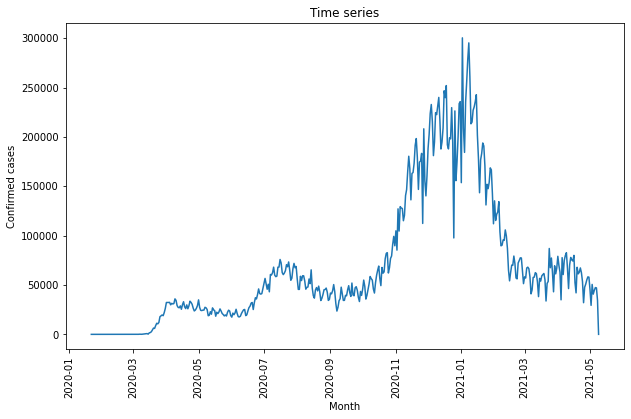

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.plot(ind)

# Set plot title and axes labels
ax.set(title = "Time series",
       xlabel = "Month",
       ylabel = "Confirmed cases")

plt.setp(ax.get_xticklabels(), rotation = 90)

plt.show()


## ETS decomposition

##### Describes Data as a as a combination of level, trend, seasonality, and noise components

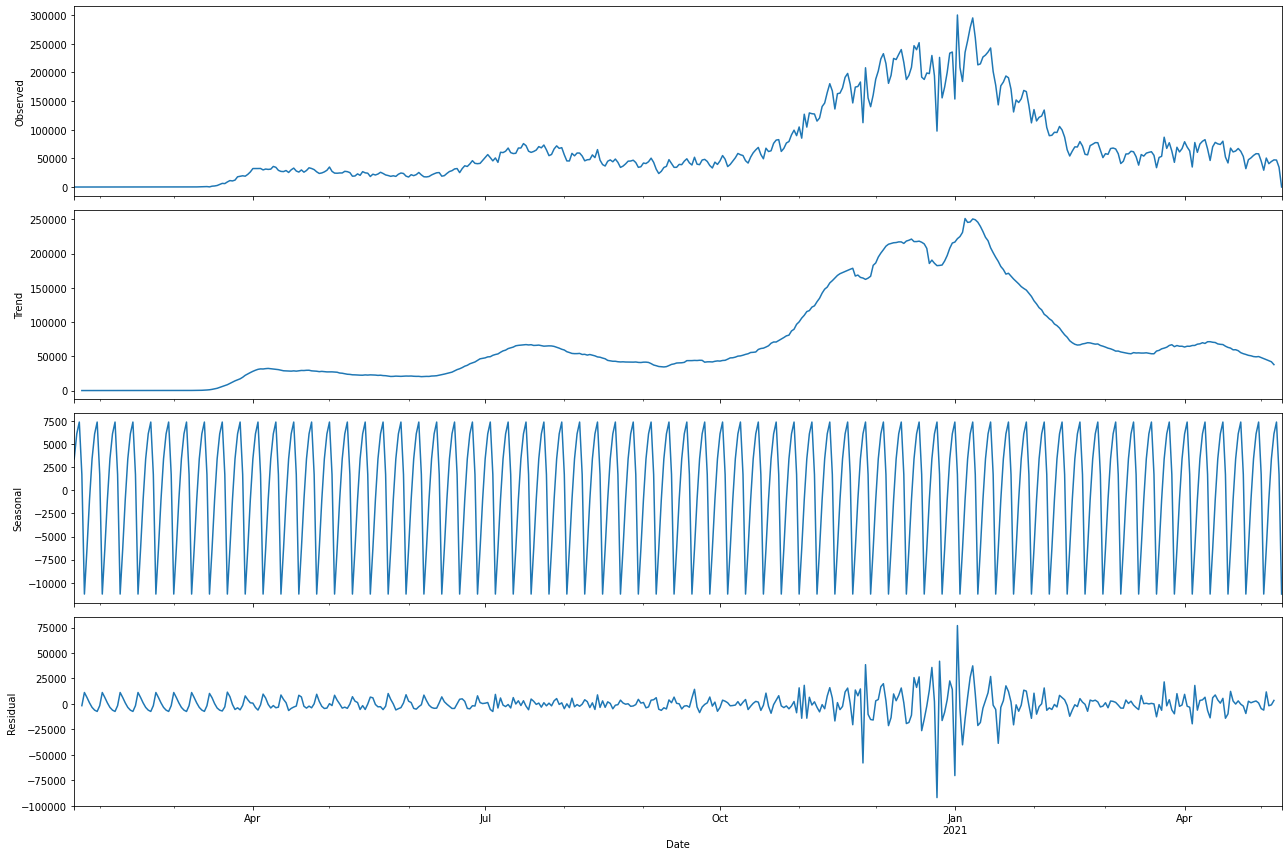

In [ ]:
#ets decomposition
rcParams['figure.figsize']=18,12
decompo= sm.tsa.seasonal_decompose(ind,model='additive')
decompo.plot();

#Testing for Stationarity

##Determine rolling stats

In [ ]:
#determine rolling stats
rolmean = country.rolling(window = 4).mean()
rolstd = country.rolling(window = 4).std()
#print(rolmean,rolstd)

##Plotting the rolling statistic

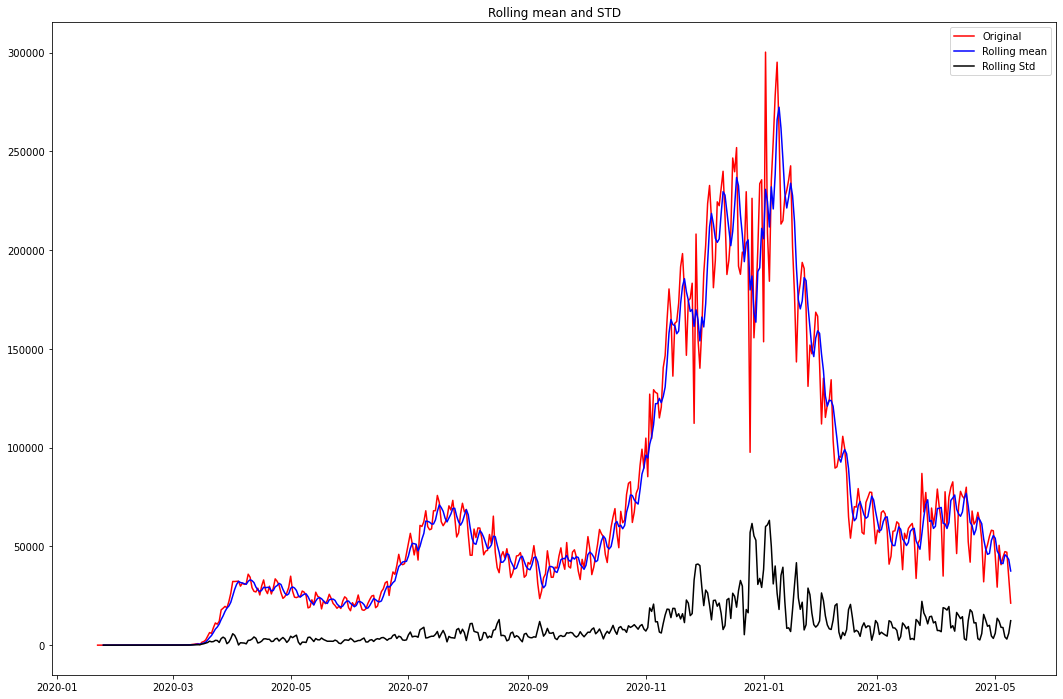

In [ ]:
# plotting the rolling statistic
orig = plt.plot(country, color = "red", label = "Original")
mean = plt.plot(rolmean, color = "blue", label = "Rolling mean")
std = plt.plot(rolstd, color = "black", label = "Rolling Std")
plt.legend(loc = "best")
plt.title("Rolling mean and STD")
plt.show(block = False)

Here both mean and std is not constant so the data is not ststionary

##Perform Dickey-Fuller test

In [ ]:
#perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print("Result of Dickey_Fuller Test:")
dftest = adfuller(ind["Confirmed"], autolag = "AIC")

dfoutput = pd.Series(dftest[0:4], index = ["Test Statistics", "p-value","#Lags Used","Number of Observations Used"])
for key,value in dftest[4].items():
    dfoutput["Critical Value (%s)"%key] = value
    
print(dfoutput)

Result of Dickey_Fuller Test:
Test Statistics                 -1.656161
p-value                          0.453829
#Lags Used                      17.000000
Number of Observations Used    456.000000
Critical Value (1%)             -3.444772
Critical Value (5%)             -2.867899
Critical Value (10%)            -2.570157
dtype: float64


Here p value is very large and Test Statistic is greater Critical value and so we don't have enough evidence to reject Null Hypothesis.
Therfore the data is non Stationary

## Splitting values for training and testing

In [ ]:
country.shape

(474, 1)

In [ ]:
#spliting the dataset
train_df = country.iloc[:430]
test_df = country.iloc[430:]

# Finding  best model

##ARIMA Model

###Define the model

In [ ]:
model = auto_arima(country["Confirmed"],seasonal=True,m=6,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=10495.636, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=10613.747, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=10539.150, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=10489.264, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=10611.751, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=10503.565, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=10491.205, Time=0.33 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=10491.103, Time=0.50 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=10491.496, Time=0.16 sec
 ARIMA(0,1,1)(1,0,2)[6] intercept   : AIC=10488.725, Time=1.60 sec
 ARIMA(0,1,1)(2,0,2)[6] intercept   : AIC=10445.532, Time=2.96 sec
 ARIMA(0,1,1)(2,0,1)[6] intercept   : AIC=10482.765, Time=1.03 sec
 ARIMA(0,1,0)(2,0,2)[6] intercept   : AIC=10585.370, Time=2.31 sec
 ARIMA(1,1,1)(2,0,2)[6] intercept   : AIC=10444.212, Time=2.92 sec
 ARIMA(1,1,1)(1,0,2

###Model Summary

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  474
Model:             SARIMAX(2, 1, 3)x(2, 0, 2, 6)   Log Likelihood               -5200.230
Date:                           Mon, 10 May 2021   AIC                          10420.460
Time:                                   06:59:29   BIC                          10462.051
Sample:                                        0   HQIC                         10436.818
                                           - 474                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1010      0.075     -1.339      0.181      -0.249       0.047
ar.L2          0.6674      0.085      7.830      0.000       0.500       0.834
ma.L1         -0.5781      0.069     -8.318      0.000      -0.714      -0.442
ma.L2         -0.7305      0.093     -7.831      0.000      -0.913      -0.548
ma.L3          0.5983      0.048     12.530      0.000       0.505       0.692
ar.S.L6        1.2600      0.042     30.227      0.000       1.178       1.342
ar.S.L12      -0.9609      0.039    -24.666      0.000      -1.037      -0.885
ma.S.L6       -1.2495      0.059    -21.021      0.000      -1.366      -1.133
ma.S.L12       0.8535      0.059     14.386      0.000       0.737       0.970
sigma2      2.416e+08   6.17e-10   3.92e+17      0.000    2.42e+08    2.42e+08
===================================================================================
Ljung-Box (Q):                      136.10   Jarque-Bera (JB):              4889.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              71.35   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.32e+32. Standard errors may be unstable.
"""

###Parameters selected from the output

In [ ]:
#parameters selected from the output
model

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 2, 6),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

### Training the model

In [ ]:
model = SARIMAX(ind["Confirmed"],order=(5, 2, 2),seasonal_order=(1, 0, 2, 6),enforce_invertibility=False)

###Fit the model

In [ ]:
result = model.fit()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         Confirmed   No. Observations:                  474
Model:             SARIMAX(5, 2, 2)x(1, 0, 2, 6)   Log Likelihood               -5226.968
Date:                           Mon, 10 May 2021   AIC                          10475.937
Time:                                   06:59:36   BIC                          10521.663
Sample:                               01-22-2020   HQIC                         10493.924
                                    - 05-09-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5942      0.030    -53.228      0.000      -1.653      -1.535
ar.L2         -0.9793      0.058    -16.758      0.000      -1.094      -0.865
ar.L3         -0.5880      0.072     -8.215      0.000      -0.728      -0.448
ar.L4         -0.4254      0.058     -7.273      0.000      -0.540      -0.311
ar.L5         -0.1850      0.026     -7.124      0.000      -0.236      -0.134
ma.L1          0.0435      0.019      2.258      0.024       0.006       0.081
ma.L2         -0.9853      0.016    -61.072      0.000      -1.017      -0.954
ar.S.L6        0.5635      0.160      3.511      0.000       0.249       0.878
ma.S.L6       -0.3763      0.164     -2.294      0.022      -0.698      -0.055
ma.S.L12      -0.2370      0.041     -5.793      0.000      -0.317      -0.157
sigma2      2.506e+08   8.62e-10   2.91e+17      0.000    2.51e+08    2.51e+08
===================================================================================
Ljung-Box (Q):                      363.22   Jarque-Bera (JB):              3275.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              76.14   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.34e+32. Standard errors may be unstable.
"""

### Testing the model for future values

Now we can predict the values into the future

In [ ]:
#Now we can predict the values into the future
start = len(train_df)
end = len(train_df) + len(test_df) - 1

In [ ]:
prediction = result.predict(start,end).rename('SARIMA model')

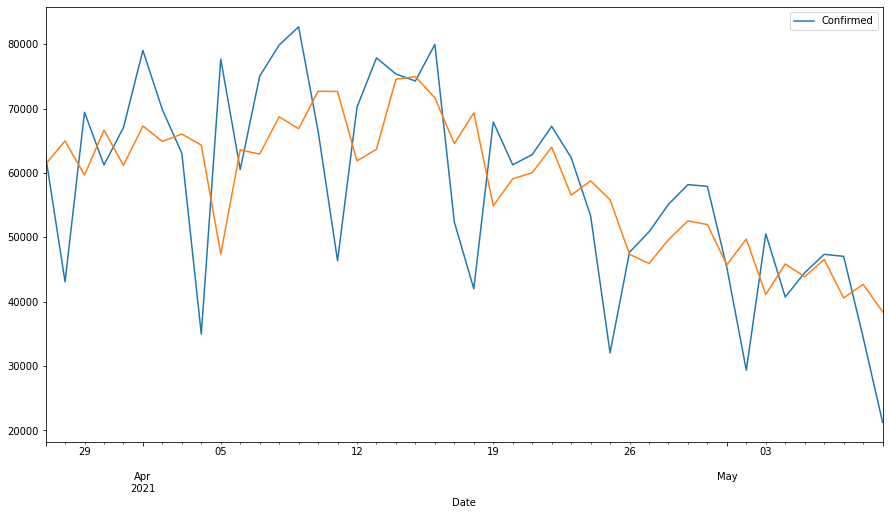

In [ ]:
test_df['Confirmed'].plot(legend=True,figsize=(15,8))
prediction.plot()

### Forcasting

In [ ]:
result_f = model.fit()

In [ ]:
fcast_cases = result_f.predict(len(country),len(country)+60,typ='levels').rename('SARIMA forecast')

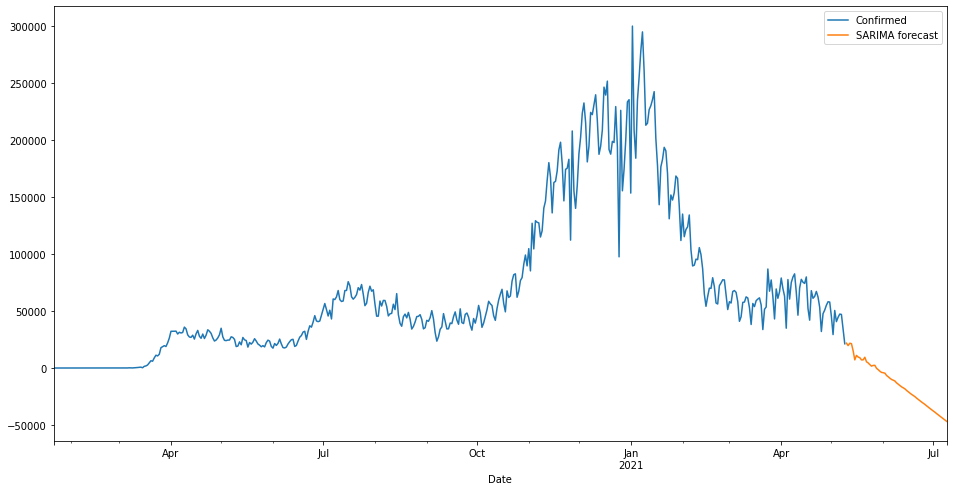

In [ ]:
# prediction
country["Confirmed"].plot(legend=True,figsize=(16,8))
fcast_cases.plot(legend=True)

## LSTM Model

###Univariate Sequence

In [ ]:
# split a univariate sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [ ]:
n_steps = 50
x,y = split_sequence(country["Confirmed"],n_steps)

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
x = x.reshape((x.shape[0], x.shape[1], n_features))

### Defining  Model

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

###Fit the model

In [ ]:
# fit model
model.fit(x, y, epochs=200, verbose=0)

###Model Summary

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


###Creating and cleaning the test data

In [ ]:
# testing data splitting
test = country1[364:]

# reserting the index to statrt from one
test.reset_index(inplace = True)

# removing the old index
test.drop("index",axis = 1,inplace = True)


### Perparing the test data 

In [ ]:
# shape of test
print("Shape of test data : ",test.shape)

# Converting test to a list of sequnces form to input to model
n_steps = 50
x_test,y_test = split_sequence(test["Confirmed"],n_steps)

Shape of test data :  (110, 2)


In [ ]:
print("Shape of x_test data : ",x_test.shape)

Shape of x_test data :  (60, 50)


### Testing the model with test data

In [ ]:
# Initialising list to store the output 
y_pred = []

In [ ]:
#testing
for i in range(len(x_test)):
    
    j= x_test[i].reshape((1, n_steps, n_features))
    yhat = model.predict(j, verbose=0)
    y_pred.append(yhat)
    

Output y_pred is now a list of arrays and converting it to a list of floats

In [ ]:
y_pred = [float(i) for i in y_pred]

### Forecasting
Plotting the perdicted and actual sequence for LSTM Model

In [ ]:
# original sequence in df
dftest = country1[364+50:]

#Preparing the original sequence dataframe
# reseting the index,
dftest.reset_index(inplace = True)

# Dropping the index
dftest.drop("index",axis =1,inplace = True)

# shape 
print("Shape of dftest data : ",dftest.shape)


Shape of dftest data :  (60, 2)


In [ ]:
# Adding the original sequence to the dataframe
dftest["Confirmed"] = pd.Series(y_test)

In [ ]:
# Preparing the predicted sequence dataframe
# fixing the index
dfpred = country1[364+50:]
dfpred.reset_index(inplace = True)
dfpred.drop("index",axis =1,inplace = True)

In [ ]:
# Adding the predicted sequence to the dataframe
dfpred["Confirmed"] = pd.Series(y_pred)

Setting the date of both dataframes as Index to make the plotting easier

In [ ]:
# changing the index as date
# for original test values
dftest["Date"] = pd.to_datetime(dftest["Date"],infer_datetime_format = True)
dftest = dftest.set_index('Date')

# changing the index as date for predicted values
dfpred["Date"] = pd.to_datetime(dfpred["Date"],infer_datetime_format = True)
dfpred = dfpred.set_index('Date')

Plotting the Predicted with the actual sequence

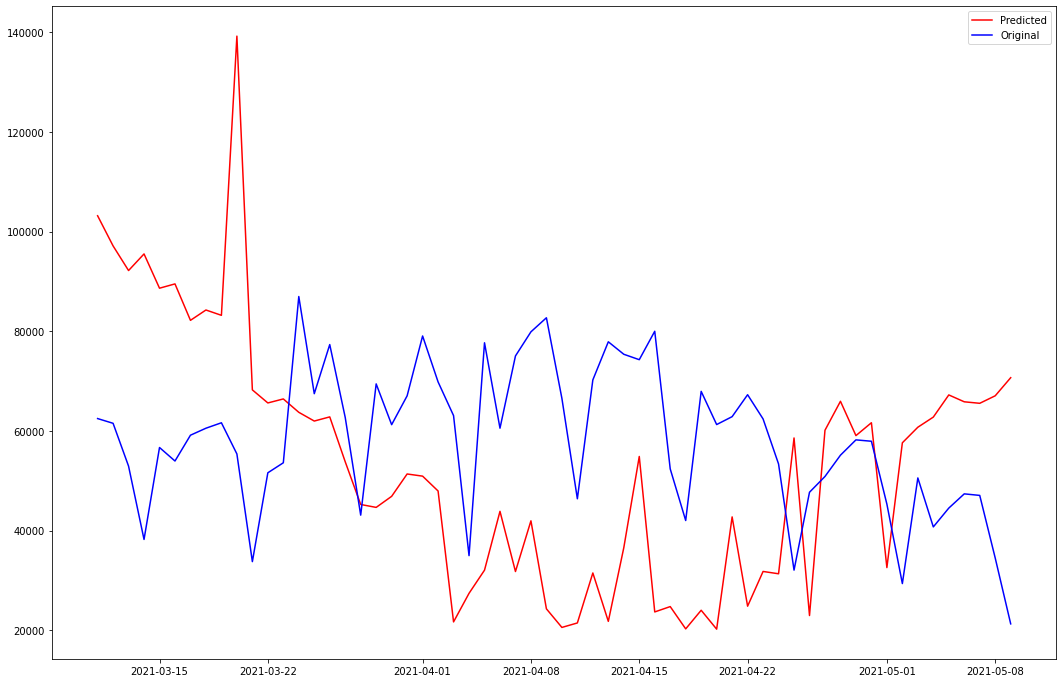

In [ ]:
plt.plot(dfpred, color = "red", label = "Predicted")#Predicted
plt.plot(dftest, color = "blue", label = "Original")#actual
plt.legend(loc = "best")